In [ ]:
%load_ext autoreload
%autoreload 2

# Grabbing the video chunks and rebuilding a file from them

In [1]:
%%writefile 2017-05-24_capture_videos_server.py
""" Computer side """

import zmq

try: 
    context = zmq.Context()                   #Creating a zmq context containing all the above
    print('Connecting to Pi...')
    dealer = context.socket(zmq.DEALER)       #Opening a socket using the zmq DEALER protocol (see zmq doc)
    dealer.connect('tcp://10.164.7.213:5555') #Connecting to the RaspBerry Pi IP adress:port
    print('Connected')
    
    print('Sending request...')
    dealer.send(b'fetch')                     #Sending the request 'if possible, send the video file'
    
    total = 0                                 #Number of bytes received
    chunks = 0                                #Number of video chunks received
    
    video = open("video_picam", "r+b")        #Opening (creating if first use) a file under "read+write in bytes' protocol
    
    while True:                               #While received chunks arn't empty, continue receiving
        chunk = dealer.recv()                 #Receiving a video chunk
        chunks += 1
        size = len(chunk)                     #Checking the chunk length (in bytes) 
        total += size
        
        print('Chunk %i received, %i bytes' % (chunks, size))
        video.write(chunk)                    #Add the last received chunk to the local file 
    
        if size == 0:               #If last received chunk is empty (whole file received), stop listening the to socket
            break
            
    print('%i chunks received, %i bytes' % (chunks, total))

finally:                                      #Close the file/connections 
    video.close()
    dealer.close()
    context.term()
    print('\nConnection closed')

Writing 2017-05-24_capture_videos_server.py


In [7]:
!ipython 2017-05-24_capture_videos_server.py

]0;IPython: Documents/IntershipConnecting to Pi...
Connected
Sending request...
Chunk 1 received, 250000 bytes
Chunk 2 received, 160161 bytes
Chunk 3 received, 0 bytes
3 chunks received, 410161 bytes

Connection closed


In [8]:
"""Checking the newly created video file length"""
try:
    video = open("video_picam", "rb")
    video.seek(0) #Starting at the first frame of the video
    vid = video.read()
    print('Video length (# of bytes) : ', len(vid))
finally:
    video.close()

Video length (# of bytes) :  418001


# Converting the video file to .avi

In [36]:
import ffmpy

ff = ffmpy.FFmpeg(inputs={'video_picam': None}, outputs={'video.mp4': None})
ff.run()

(None, None)

# Displaying the video file

In [37]:
from moviepy import *
from moviepy.editor import *

clip = VideoFileClip('video.mp4').rotate(90)
clip.ipython_display()

 99%|█████████▉| 156/157 [00:02<00:00, 57.74it/s]


# Perform video processing

frame  1


TypeError: 'AxesImage' object is not callable

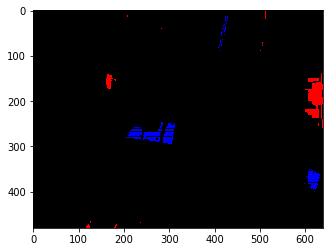

In [18]:
%matplotlib inline

from moviepy import *
from moviepy.editor import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Simulating the openRetina parameters before introducing the script into it
h, w = 480, 640
sparseness = 0.01
rgb2gray=[0.2989, 0.5870, 0.1140]
output = 'video_processed.mp4'

n_datapoints = int(np.ceil(sparseness*h*w)) #Calculating the maximum number of data points according to these paramaters
frame_old = np.zeros((h, w))                #Creating a correctly sized frame containing only zeros

video = VideoFileClip('video.mp4', audio=False)
videobis = video.copy()
i = 1
frames = video.iter_frames()                #Creating a variable containing every video frames

for frame in video.iter_frames():           #For each of these frames
    print('frame ', i)
    i += 1

    #frame_cc = plt.imshow(frame)
    frame = frame.astype(np.float)          #Convert the data to float (modifications will be easier)
    frame *= np.array(rgb2gray)[np.newaxis, np.newaxis, :]
    frame = frame.sum(axis=-1)              #Sum the data along an axis (negative : count from the last to the first axis)
    dframe = frame - frame_old              #Calculate the differences between the current frame and the previous one
    frame_old = frame                       #Redefining the 'previous frame' for the next iteration

    data_ = np.argsort(dframe.ravel()) #Put the data into one dimension and sort it; return the indices (initial position #)
    data = np.hstack((data_[:n_datapoints], data_[-n_datapoints:]))

    frame = np.zeros((h, w, 3), dtype = np.uint8)
    frame[:, :, 0][np.unravel_index(data[:n_datapoints], (h, w))] = 255
    frame[:, :, -1][np.unravel_index(data[-n_datapoints:], (h, w))] = 255
    
    frame_new = plt.imshow(frame)
    videobis.fl_image(frame_new)
    
    #print(frame)

In [20]:
%matplotlib inline

from moviepy import *
from moviepy.editor import *
import numpy as np

#Simulating the openRetina parameters before introducing the script into it
h, w = 480, 640
sparseness = 0.01
rgb2gray=[0.2989, 0.5870, 0.1140]
output = 'video_processed.mp4'

n_datapoints = int(np.ceil(sparseness*h*w)) #Calculating the maximum number of data points according to these paramaters
frame_old = np.zeros((h, w))                #Creating a correctly sized frame containing only zeros

video = VideoFileClip('video.mp4', audio=False)

def process(frame, frame_old=np.zeros((h,w))):
    frame = frame.astype(np.float)          #Convert the data to float (modifications will be easier)
    frame *= np.array(rgb2gray)[np.newaxis, np.newaxis, :]
    frame = frame.sum(axis=-1)              #Sum the data along an axis (negative : count from the last to the first axis)
    dframe = frame - frame_old              #Calculate the differences between the current frame and the previous one
    frame_old = frame                       #Redefining the 'previous frame' for the next iteration

    data_ = np.argsort(dframe.ravel()) #Put the data into one dimension and sort it; return the indices (initial position #)
    data = np.hstack((data_[:n_datapoints], data_[-n_datapoints:]))

    frame = np.zeros((h, w, 3), dtype = np.uint8)
    frame[:, :, 0][np.unravel_index(data[:n_datapoints], (h, w))] = 255
    frame[:, :, -1][np.unravel_index(data[-n_datapoints:], (h, w))] = 255

    return frame

processed_video = video.fl_image(process)
processed_video.write_videofile('processed_video.mp4')

#print(frame)

[MoviePy] >>>> Building video processed_video.mp4
[MoviePy] Writing video processed_video.mp4


 99%|█████████▉| 156/157 [00:07<00:00, 20.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.mp4 



# Displaying the processed video file

In [87]:
from moviepy import *
from moviepy.editor import *

clip = VideoFileClip('video_traited.mp4').rotate(90)
clip.ipython_display()

 99%|█████████▉| 156/157 [00:03<00:00, 49.73it/s]
